# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score ,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast

# Setting a Random Seed for Reproducibility

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")

CUDA is available, using GPU.


# Loading Data

In [3]:
# Load the dataset
base_dir = '/kaggle/input/not-beautifull-marketplace'
train_df = pd.read_csv("/kaggle/input/not-beautifull-marketplace/train .csv")
test_df = pd.read_csv("/kaggle/input/not-beautifull-marketplace/test.csv")

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (8952, 2)
Test dataset shape: (2064, 1)


# Preprocessing

In [4]:
train_df = train_df

# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
test_df['id'] = base_dir+'/test/test/'+test_df['id']
train_df['id'] = base_dir+'/train/train/'+train_df['target'].astype(str)+'/'+train_df['id']

In [5]:
train_df

,id,target
0,/kaggle/input/not-beautifull-marketplace/train...,1
1,/kaggle/input/not-beautifull-marketplace/train...,1
2,/kaggle/input/not-beautifull-marketplace/train...,1
3,/kaggle/input/not-beautifull-marketplace/train...,1
4,/kaggle/input/not-beautifull-marketplace/train...,1
...,...,...
8947,/kaggle/input/not-beautifull-marketplace/train...,1
8948,/kaggle/input/not-beautifull-marketplace/train...,1
8949,/kaggle/input/not-beautifull-marketplace/train...,1
8950,/kaggle/input/not-beautifull-marketplace/train...,1


In [6]:
# ✅ Split the train_df DataFrame itself, NOT just 'file_name' and 'label' separately
train_df, val_df = train_test_split(
    train_df,  
    test_size=0.1,        
    stratify=train_df['target'],  
    random_state=42
)

# ✅ Print checks
print(f"Train Data: {len(train_df)}")
print(f"Validation Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")  # Test data remains unchanged


Train Data: 8056
Validation Data: 896
Test Data: 2064


# Data Augmentation

In [7]:
# ✅ Training Transformations (with Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((232)),                
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(10),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),        
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])                        
    
# ✅ Testing Transformations (NO Augmentation)
test_transforms = transforms.Compose([
    transforms.Resize(232),  
    transforms.CenterCrop(224),             
    transforms.ToTensor(),                        
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   
])


# Creating a Custom Dataset Class

In [8]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform
        self.is_test = is_test  # Test dataset flag

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["id"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img  # No label for test dataset
        else:
            label = self.df.iloc[idx]["target"]
            return img, label

In [9]:
# ✅ Train & Validation Datasets
train_dataset = CustomDataset(df=train_df, transform=train_transforms)
val_dataset = CustomDataset(df=val_df, transform=test_transforms)

batch_size = 16
# ✅ DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
batch_images, batch_labels = next(iter(train_loader))
print(f"Batch shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")

Batch shape: torch.Size([16, 3, 224, 224]), Labels shape: torch.Size([16])


In [11]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")

CUDA Available: True
Device: cuda


# Model (ConvNeXt Large + Swin Transformer)

In [12]:
import torch
import torch.nn as nn
from timm import create_model

class ViTConXWithAvgPooling(nn.Module):
    def __init__(self, num_classes=1):
        super(ViTConXWithAvgPooling, self).__init__()

        # Load ConvNeXt Large
        self.convnext = create_model("convnext_large", pretrained=True, num_classes=0)
        convnext_out = self.convnext.num_features

        # Load Swin Transformer
        self.swin = create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=0)
        swin_out = self.swin.num_features

        # Global Average Pooling for each model
        self.global_avg_pooling_convnext = nn.AdaptiveAvgPool1d(1)
        self.global_avg_pooling_swin = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layers for feature fusion
        self.feature_fusion = nn.Sequential(
            nn.BatchNorm1d(convnext_out + swin_out),
            nn.Linear(convnext_out + swin_out, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        
        # Decoder: Additional layers to output classification results
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  
        )

    def forward(self, x):
        # Pass through ConvNeXt and Swin Transformer
        x_convnext = self.convnext(x)
        x_swin = self.swin(x)

        # Debug print statements to inspect tensor shapes
        #print("Shape of x_convnext before pooling:", x_convnext.shape)
        #print("Shape of x_swin before pooling:", x_swin.shape)

        # Apply global average pooling
        x_convnext = self.global_avg_pooling_convnext(x_convnext.unsqueeze(2)).view(x_convnext.size(0), -1)
        x_swin = self.global_avg_pooling_swin(x_swin.unsqueeze(2)).view(x_swin.size(0), -1)

        # Debug print statements to inspect tensor shapes after pooling
        #print("Shape of x_convnext after pooling:", x_convnext.shape)
        #print("Shape of x_swin after pooling:", x_swin.shape)

        # Concatenate both feature vectors
        x_combined = torch.cat((x_convnext, x_swin), dim=1)
        x_fused = self.feature_fusion(x_combined)

        # Pass through the decoder to output the final classification result
        decoded_output = self.decoder(x_fused)

        return decoded_output

# Initialize the model with ConvNeXt Large and Swin Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTConXWithAvgPooling(num_classes=1).to(device)

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [13]:
# Freeze All Layers
for param in model.convnext.parameters():
    param.requires_grad = False

for param in model.swin.parameters():
    param.requires_grad = False

# Unfreeze Last 10 Layers
for param in list(model.convnext.parameters()):
    param.requires_grad = True

for param in list(model.swin.parameters()):
    param.requires_grad = True

    
# Prepare optimizer
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Define Loss Function
criterion = nn.BCEWithLogitsLoss().to(device)

In [14]:
torch.cuda.empty_cache()

# Training 

In [15]:
# Initialize GradScaler for mixed precision training
scaler = GradScaler(device='cuda')

# Initialize lists to store training progress
train_losses, train_accuracies = [], []
val_losses, val_accuracies, val_f1_scores, val_roc_aucs = [], [], [], []

epochs = 3
patience = 1
best_val_loss = float("inf")
epochs_without_improvement = 0  

for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_accuracy = 0.0, 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device).float()

        optimizer.zero_grad()

        # Mixed precision training
        with autocast(device_type='cuda'):
            output = model(data).squeeze(1)
            loss = criterion(output, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).float()
        epoch_accuracy += (preds == label).float().mean().item()

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    val_pred_classes, val_labels_list = [], []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device).float()

            with autocast(device_type='cuda'):
                output = model(data).squeeze(1)
                loss = criterion(output, label)

            val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).float()
            val_acc += (preds == label).float().mean().item()

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_f1 = f1_score(np.array(val_labels_list, dtype=int), 
                      np.array(val_pred_classes, dtype=int))
    val_roc_auc = roc_auc_score(np.array(val_labels_list, dtype=int), 
                                np.array(val_pred_classes, dtype=int))

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_roc_aucs.append(val_roc_auc)

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val ROC AUC: {val_roc_auc:.4f}")

    scheduler.step()

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_weights.pth')  
        torch.save(model, 'best_model.pth')  # Save both model and weights
        print(" Model saved!")
        epochs_without_improvement = 0  # Reset counter after improvement
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            break

Validation Epoch 1: 100%|██████████| 56/56 [00:22<00:00,  2.46it/s]


Epoch [1/3] Train Loss: 0.3850 | Train Acc: 0.8113 | Val Loss: 0.1824 | Val Acc: 0.9241 | Val F1: 0.9432 | Val ROC AUC: 0.9204
 Model saved!


Validation Epoch 2: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]


Epoch [2/3] Train Loss: 0.2940 | Train Acc: 0.8744 | Val Loss: 0.1651 | Val Acc: 0.9420 | Val F1: 0.9562 | Val ROC AUC: 0.9463
 Model saved!


Validation Epoch 3: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]

Epoch [3/3] Train Loss: 0.2702 | Train Acc: 0.8869 | Val Loss: 0.1761 | Val Acc: 0.9330 | Val F1: 0.9494 | Val ROC AUC: 0.9361
⚠️ Early stopping at epoch 3


# Plot

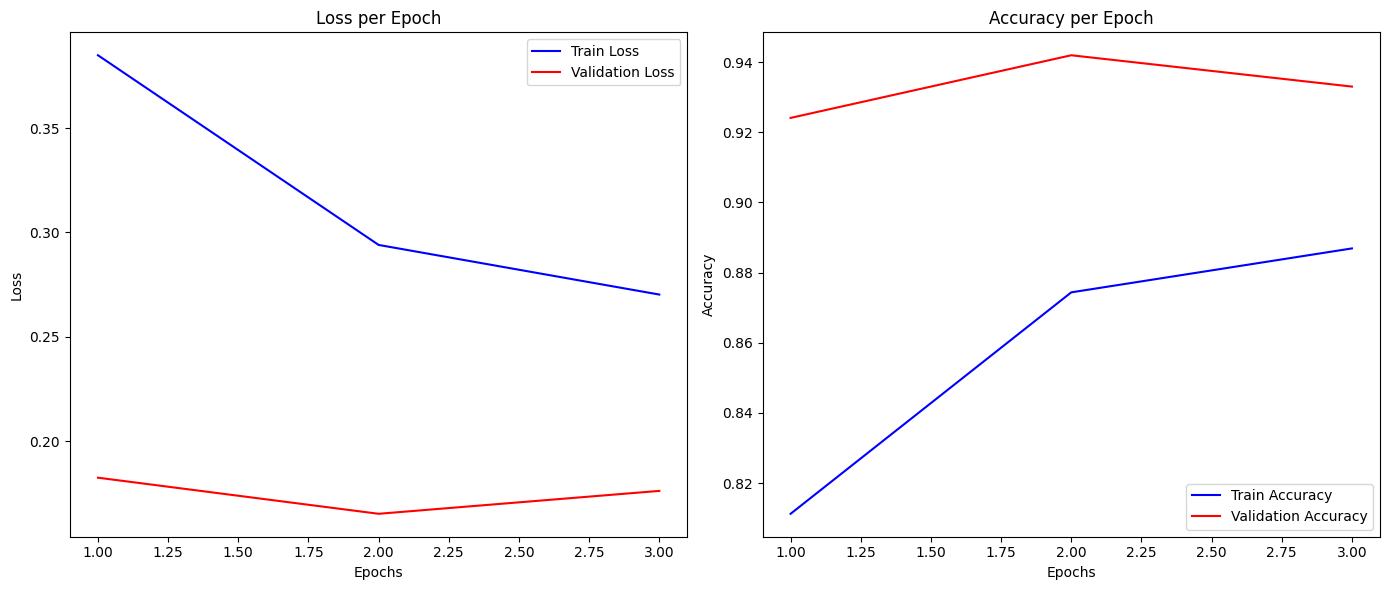

In [16]:
# Plot Loss and Accuracy

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
axs[1].set_title('Accuracy per Epoch')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.savefig('Accuracy per Epoch.png')
plt.show()

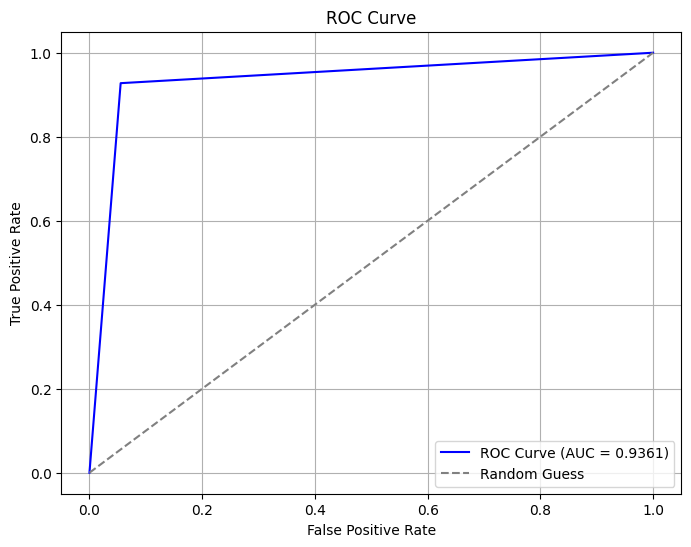

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, _ = roc_curve(np.array(val_labels_list, dtype=int), np.array(val_pred_classes, dtype=int))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {val_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


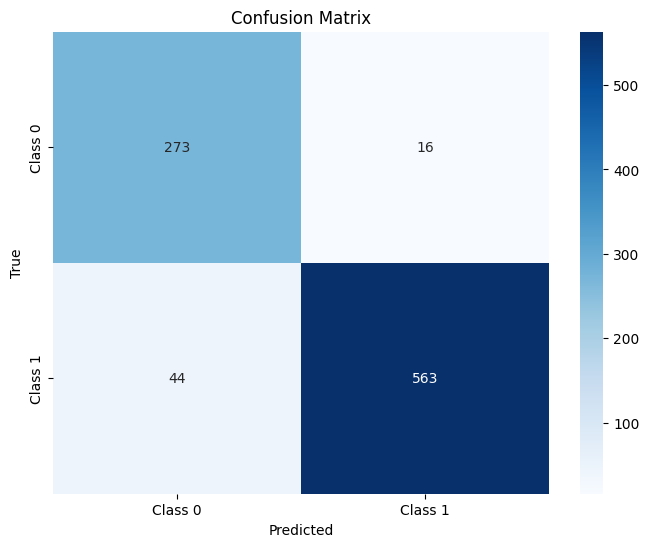


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       289
         1.0       0.97      0.93      0.95       607

    accuracy                           0.93       896
   macro avg       0.92      0.94      0.93       896
weighted avg       0.94      0.93      0.93       896



In [18]:
# Generate and plot Confusion Matrix
conf_matrix = confusion_matrix(val_labels_list, val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(val_labels_list, val_pred_classes))

# Prediction

In [19]:
# ✅ Test Dataset (NO Labels)
class CustomTestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img_path = self.df.iloc[idx]["id"]
            img = Image.open(img_path).convert("RGB")
    
            if self.transform:
                img = self.transform(img)

            return img  # No label for test dataset
        except Exception:
            return img_path

In [20]:
# ✅ Test Dataset
test_dataset = CustomTestDataset(df=test_df, transform=test_transforms)

# ✅ Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 2064


In [21]:
# ✅ Set model to evaluation mode
model.eval()

# ✅ List to store predictions
test_predictions = []
none = []
count_of_none = 0
# ✅ Disable gradient computation (since we're not training)
with torch.no_grad():
    for data in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        if type(data[0])==str:
            none.append(data)
            test_predictions.extend([1])
        else:
            # Move data to device
            data = data.to(device)
    
            # Forward pass
            output = model(data).squeeze(1)  # Ensure correct dimensions
    
            # Apply sigmoid activation to convert logits to probabilities
            probs = torch.sigmoid(output)
    
            # Convert probabilities to binary class (0 or 1) using threshold 0.5
            preds = (probs > 0.5).int()
    
            # Store predictions
            test_predictions.extend(preds.cpu().numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions, dtype=int)

Inference Progress: 100%|██████████| 2064/2064 [02:03<00:00, 16.66it/s]


In [22]:
# ✅ Create Submission DataFrame using `test_df`
submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])  
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["target"] = test_predictions

In [23]:
submission_df

,id,target
0,test_data_v2/10000255.jpg,1
1,test_data_v2/100158667.jpg,0
2,test_data_v2/100158669.jpg,0
3,test_data_v2/100204647.jpg,0
4,test_data_v2/100228704.jpg,0
...,...,...
2059,test_data_v2/99711172.jpg,0
2060,test_data_v2/99744533.jpg,0
2061,test_data_v2/99835453.jpg,0
2062,test_data_v2/99837411.jpg,0


In [24]:
samp = pd.read_csv('/kaggle/input/not-beautifull-marketplace/sample_submition.csv')

In [25]:
samp['target'] = submission_df['target']
samp

,target
0,1
1,0
2,0
3,0
4,0
...,...
2059,0
2060,0
2061,0
2062,0


In [26]:
# ✅ Save CSV file
samp.to_csv("submission.csv", index=False)